
### Обучить СНС с помощью Transfer Learning на датасете Food-101¶
##### Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
##### Библиотеки: [Python, Tensorflow]



In [1]:
%tensorflow_version 2.x

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.applications import MobileNetV2

#### Загрузка датасета

In [15]:
(train_ds, valid_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]', 'validation'],
)

In [11]:
# https://github.com/alpapado/food-101/blob/master/data/meta/labels.txt
labels = ['Apple pie','Baby back ribs','Baklava','Beef carpaccio','Beef tartare',
          'Beet salad','Beignets','Bibimbap','Bread pudding','Breakfast burrito',
          'Bruschetta','Caesar salad','Cannoli','Caprese salad','Carrot cake',
          'Ceviche','Cheesecake','Cheese plate','Chicken curry','Chicken quesadilla',
          'Chicken wings','Chocolate cake','Chocolate mousse','Churros',
          'Clam chowder','Club sandwich','Crab cakes','Creme brulee','Croque madame',
          'Cup cakes','Deviled eggs','Donuts','Dumplings','Edamame','Eggs benedict',
          'Escargots','Falafel','Filet mignon','Fish and chips','Foie gras','French fries',
          'French onion soup','French toast','Fried calamari','Fried rice','Frozen yogurt',
          'Garlic bread','Gnocchi','Greek salad','Grilled cheese sandwich','Grilled salmon',
          'Guacamole','Gyoza','Hamburger','Hot and sour soup','Hot dog','Huevos rancheros',
          'Hummus','Ice cream','Lasagna','Lobster bisque','Lobster roll sandwich',
          'Macaroni and cheese','Macarons','Miso soup','Mussels','Nachos','Omelette',
          'Onion rings','Oysters','Pad thai','Paella','Pancakes','Panna cotta',
          'Peking duck','Pho','Pizza','Pork chop','Poutine','Prime rib',
          'Pulled pork sandwich','Ramen','Ravioli','Red velvet cake','Risotto',
          'Samosa','Sashimi','Scallops','Seaweed salad','Shrimp and grits',
          'Spaghetti bolognese','Spaghetti carbonara','Spring rolls','Steak',
          'Strawberry shortcake','Sushi','Tacos','Takoyaki','Tiramisu','Tuna tartare',
          'Waffles']
num_classes = len(labels)

#### Визуализация датасета

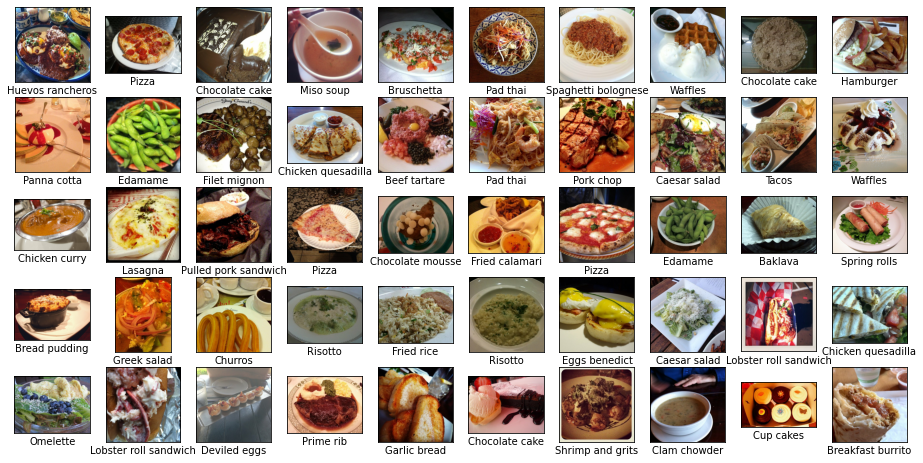

In [13]:
some_samples = [x for x in iter(train_ds.take(50))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(5, 10, j+1)
    ax.imshow(some_samples[j][0])
    plt.xticks([]), plt.yticks([])
    plt.xlabel(labels[some_samples[j][1]])
plt.show()

#### Создание пайплайна данных

In [16]:
INP_SIZE = 224
BATCH_SIZE = 32

def prepare(img, label):
  img = tf.cast(img, tf.float32)/127. - 1.
  return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

valid_ds = valid_ds.shuffle(buffer_size=1000)
valid_ds = valid_ds.map(prepare)
valid_ds = valid_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
est_ds = test_ds.batch(128, drop_remainder=True)

### CNN c аугментацией

#### Подготовка модели CNN

In [18]:
img_augmentation = Sequential([
    layers.RandomRotation(factor=0.15),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
])


base_model = MobileNetV2(weights="imagenet", include_top=False,
                         input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))

inputs = layers.Input(shape=(INP_SIZE, INP_SIZE, 3))
x = img_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# fix train, do not learn first layers
for layer in base_model.layers:
    layer.trainable = False

#### Подготовка к обучению

In [19]:
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss_model = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, 
    name='sparse_categorical_crossentropy'
)

model.compile(optimizer=optimizer,
              loss=loss_model,
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min',
                                                    restore_best_weights=True)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
Total params: 2,387,365
Trainable params: 129,381
Non-trainable params: 2,257,984
_____________________________________________

#### Обучение модели

In [21]:
%%time

history = model.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds,
    callbacks=[early_stopping])

Epoch 1/20
2130/2130 [==============================] - 339s 143ms/step - loss: 2.5267 - accuracy: 0.3962 - val_loss: 1.8477 - val_accuracy: 0.5305
Epoch 2/20
2130/2130 [==============================] - 299s 140ms/step - loss: 2.1474 - accuracy: 0.4732 - val_loss: 1.7904 - val_accuracy: 0.5474
Epoch 3/20
2130/2130 [==============================] - 299s 140ms/step - loss: 2.0800 - accuracy: 0.4857 - val_loss: 1.8095 - val_accuracy: 0.5401
Epoch 4/20
2130/2130 [==============================] - 317s 148ms/step - loss: 2.0513 - accuracy: 0.4938 - val_loss: 1.7894 - val_accuracy: 0.5473
Epoch 5/20
2130/2130 [==============================] - 319s 149ms/step - loss: 2.0254 - accuracy: 0.5023 - val_loss: 1.7997 - val_accuracy: 0.5452
Epoch 6/20
2130/2130 [==============================] - 320s 149ms/step - loss: 2.0203 - accuracy: 0.5040 - val_loss: 1.7711 - val_accuracy: 0.5555
Epoch 7/20
2130/2130 [==============================] - 306s 143ms/step - loss: 2.0127 - accuracy: 0.5067 - val_

#### Оценка качества модели

In [22]:
%%time

model.evaluate(test_ds)

197/197 [==============================] - 103s 480ms/step - loss: 1.5424 - accuracy: 0.5927
CPU times: user 2min 53s, sys: 7.38 s, total: 3min
Wall time: 1min 42s


[1.5424251556396484, 0.5926792621612549]

### CNN без аугментации¶

In [23]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(101, activation='softmax')(x)

model2 = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# fix train, not learning first layers
for layer in base_model.layers:
    layer.trainable = False

#### Подготовка к обучению

In [24]:
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_model = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, 
    name='sparse_categorical_crossentropy'
)

model2.compile(optimizer=optimizer,
              loss=loss_model,
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min',
                                                    restore_best_weights=True)

In [25]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

#### Обучение модели

In [26]:
%%time

history2 = model2.fit(
    train_ds,
    epochs=150,
    validation_data=valid_ds,
    callbacks=[early_stopping])

Epoch 1/150
2130/2130 [==============================] - 305s 139ms/step - loss: 2.1951 - accuracy: 0.4604 - val_loss: 1.7844 - val_accuracy: 0.5463
Epoch 2/150
2130/2130 [==============================] - 290s 135ms/step - loss: 1.7168 - accuracy: 0.5625 - val_loss: 1.7097 - val_accuracy: 0.5753
Epoch 3/150
2130/2130 [==============================] - 308s 144ms/step - loss: 1.6034 - accuracy: 0.5864 - val_loss: 1.7076 - val_accuracy: 0.5775
Epoch 4/150
2130/2130 [==============================] - 290s 135ms/step - loss: 1.5373 - accuracy: 0.6001 - val_loss: 1.7161 - val_accuracy: 0.5718
Epoch 5/150
2130/2130 [==============================] - 291s 136ms/step - loss: 1.5008 - accuracy: 0.6083 - val_loss: 1.7260 - val_accuracy: 0.5732
Epoch 6/150
2130/2130 [==============================] - 309s 144ms/step - loss: 1.4689 - accuracy: 0.6131 - val_loss: 1.7498 - val_accuracy: 0.5752
Epoch 7/150
2130/2130 [==============================] - 293s 137ms/step - loss: 1.4512 - accuracy: 0.6181

In [ ]:
%%time

model.evaluate(test_ds)

#### Оценка качества модели

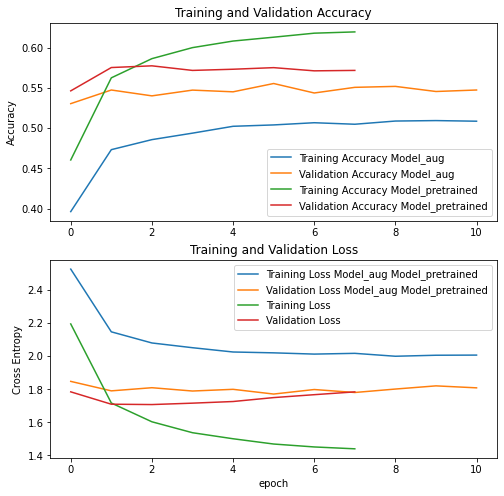

In [27]:
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']

loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc1, label='Training Accuracy Model_aug')
plt.plot(val_acc1, label='Validation Accuracy Model_aug')
plt.plot(acc2, label='Training Accuracy Model_pretrained')
plt.plot(val_acc2, label='Validation Accuracy Model_pretrained')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss1, label='Training Loss Model_aug Model_pretrained')
plt.plot(val_loss1, label='Validation Loss Model_aug Model_pretrained')
plt.plot(loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Оценка качества модели

In [32]:
%%time

model2.evaluate(test_ds)

197/197 [==============================] - 97s 477ms/step - loss: 1.4682 - accuracy: 0.6109
CPU times: user 2min 53s, sys: 7.41 s, total: 3min 1s
Wall time: 1min 37s


[1.468177318572998, 0.6109216213226318]

#### Предсказание 

In [2]:
some_samples = []
some_labels =[] 
for x in iter(test_ds.take(4)):
    some_samples.append(x[0])
    some_labels.append(x[1]) 

NameError: ignored

In [51]:
pred = model2.predict(some_samples[0])
pred_y = tf.argmax(pred, axis=1, output_type=tf.int32)

In [52]:

fig = plt.figure(figsize=(15, 30))
for j in range(len(some_samples[0])):
    ax = fig.add_subplot(16, 8, j+1)
    ax.imshow(some_samples[0][j])
    ax.title.set_text(f'true: {labels[some_labels[0][j]]}\n pred: {labels[pred_y[j]]}')
    plt.xticks([]), plt.yticks([])
plt.show()

Output hidden; open in https://colab.research.google.com to view.